In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib.dates import DateFormatter

from load_wastewater_data import *

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_04_03"

substance = "COVID" # one of PMMoV, COVID
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [3]:
df = load_systems_data(experiment_series, substance, rain_scenario, degradation_setting, file_type="concentrations")

In [4]:
plot_path = f"../plots/sampling_strategies"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{substance}_{rain_scenario}_{degradation_setting}"

## Preprocessing

In [5]:
def simulate_sampling_strategies(df):
    df.time = pd.to_datetime(df.time)
    df["day"]= [el.day for el in df.time]
    df["hour"] = [el.hour for el in df.time]

    # consider only valid observations, i.e. with t>0
    df = df.loc[df.minutes >= 0,:]
    # resample every 5 minutes and fill with the last available value
    resampled_df = df.set_index("time").groupby(["sampling_point", "memilio_id"]).resample("5min").ffill()
    # get hourly measurements
    resampled_df = resampled_df.loc[resampled_df.minutes.mod(60) == 0,:]
    # fix column naming and index
    resampled_df.index = [el[2] for el in resampled_df.index]
    resampled_df = resampled_df.reset_index().rename(columns={"index": "time"})
    # calculate 24h samples
    df_24h = resampled_df.groupby(["sampling_point", "memilio_id", "day"]).mean().reset_index().rename(columns={"copies/l": "24h_sample"})
    # only consider 24h samples with 24h of data
    df_24h = df_24h.loc[df_24h.hour==11.5, ["time", "sampling_point", "memilio_id", "24h_sample"]]
    # extract morning sample column
    df_morning_sample = resampled_df.loc[resampled_df.hour==10,:].rename(columns={"copies/l": "morning_sample"}).loc[:,  ["time", "sampling_point", "memilio_id", "morning_sample"]]
    # combine everything
    df_measurements = pd.merge(resampled_df, pd.merge(df_24h, df_morning_sample, on=["sampling_point", "memilio_id", "time"], how="outer"), on=["sampling_point", "memilio_id", "time"], how="outer")
    return df_measurements

In [6]:
df_sampling = simulate_sampling_strategies(df)

In [7]:
# from wide to long
df_sampling = pd.melt(df_sampling, id_vars=["time", "sampling_point", "memilio_id"], value_vars=["24h_sample", "morning_sample", "copies/l"]).dropna()

## Visualizations

In [14]:
def plot_sampling_strategies(df_sampling, station, save_fig=False):
    fig, ax = plt.subplots(figsize = (12,6)) 
    sns.lineplot(df_sampling.loc[df_sampling.sampling_point==station, :], x="time", y="value", hue="variable")
    plt.ylabel('virus levels [copies/l]', fontsize=15)
    date_form = DateFormatter("%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel(f"simulation time [days]", fontsize=15)
    ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels, ['24h sample', 'morning sample','simulation result'], title="sampling protocol", fontsize=12)    
    if save_fig:
        plt.tight_layout()
        plt.savefig(os.path.join(plot_path, f"{file_name_prefix}_station_{station}.png"))
        plt.close(fig)
    else:
        plt.close(fig)
        return fig

/tmp/ipykernel_232370/1286274771.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


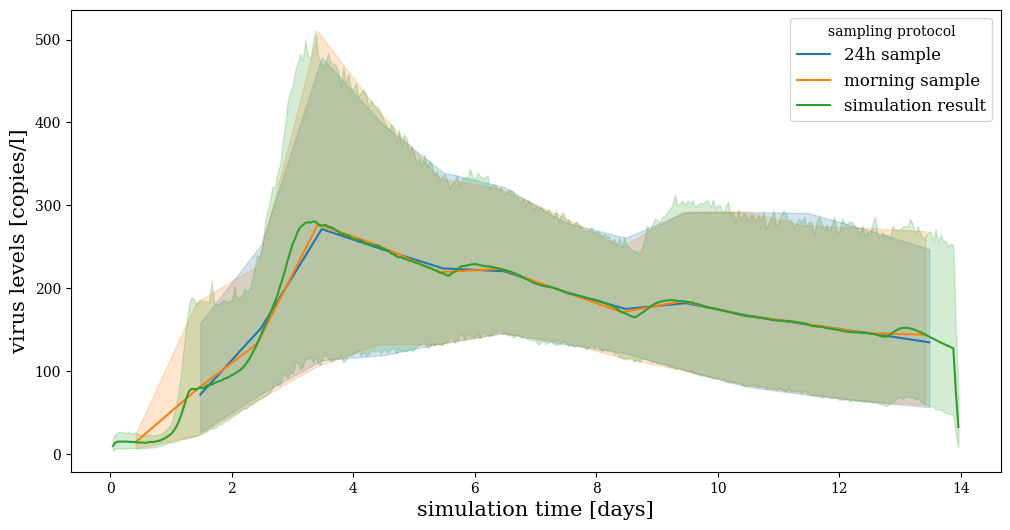

In [12]:
plot_sampling_strategies(df_sampling, "1", save_fig=False)

In [15]:
for station in ["16"]: # ["1", "2", "8", "16"]: # df_sampling.sampling_point.unique():
    plot_sampling_strategies(df_sampling, station, save_fig=True)

/tmp/ipykernel_232370/889672678.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
